In [14]:
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf

In [15]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()

In [16]:
(X_train_full , Y_train_full) , (X_test , Y_test) = fashion_mnist
X_train , Y_train = X_train_full[:-5000] , Y_train_full[:-5000]
X_valid , Y_valid = X_train_full[-5000:] , Y_train_full[-5000:]

In [17]:
X_train, X_valid , X_test = X_train / 255 , X_valid/255 , X_test/255

In [18]:
X_train.shape

(55000, 28, 28)

In [19]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [20]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = [28,28]),
    tf.keras.layers.Dense(300, activation = tf.keras.activations.relu),
    tf.keras.layers.Dense(100, activation = tf.keras.activations.relu),
    tf.keras.layers.Dense(10, activation = tf.keras.activations.softmax)
])

In [21]:
model.compile(loss =tf.keras.losses.sparse_categorical_crossentropy,
              optimizer = tf.keras.optimizers.SGD(),
              metrics = [tf.keras.metrics.sparse_categorical_accuracy])

In [22]:
h= model.fit(X_train, Y_train , epochs = 30, validation_split = 0.1 , batch_size = 32)

Epoch 1/30
1547/1547 [==============================] - 15s 9ms/step - loss: 0.7480 - sparse_categorical_accuracy: 0.7551 - val_loss: 0.5566 - val_sparse_categorical_accuracy: 0.8105
Epoch 2/30
1547/1547 [==============================] - 12s 8ms/step - loss: 0.5010 - sparse_categorical_accuracy: 0.8256 - val_loss: 0.4891 - val_sparse_categorical_accuracy: 0.8313
Epoch 3/30
1547/1547 [==============================] - 7s 5ms/step - loss: 0.4534 - sparse_categorical_accuracy: 0.8415 - val_loss: 0.4604 - val_sparse_categorical_accuracy: 0.8429
Epoch 4/30
1547/1547 [==============================] - 9s 6ms/step - loss: 0.4256 - sparse_categorical_accuracy: 0.8508 - val_loss: 0.4600 - val_sparse_categorical_accuracy: 0.8389
Epoch 5/30
1547/1547 [==============================] - 8s 5ms/step - loss: 0.4041 - sparse_categorical_accuracy: 0.8587 - val_loss: 0.4206 - val_sparse_categorical_accuracy: 0.8520
Epoch 6/30
1547/1547 [==============================] - 8s 5ms/step - loss: 0.3873 - spa

<Axes: xlabel='Epoch'>

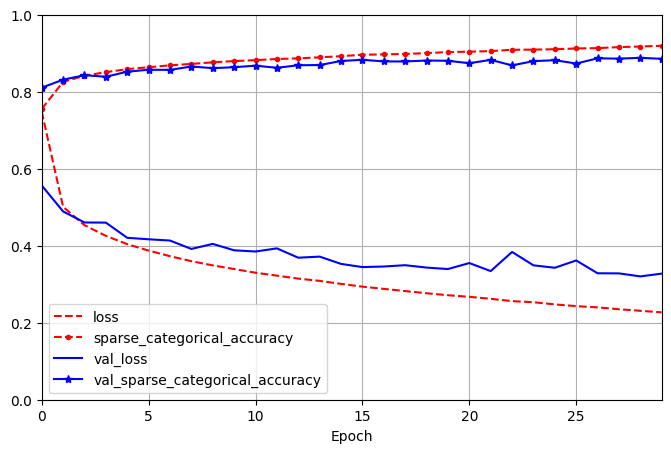

In [23]:
pd.DataFrame(h.history).plot(figsize = (8,5), xlim = [0,29], ylim = [0,1], grid = True, xlabel = 'Epoch',
                             style = ['r--', 'r--.', 'b-', 'b-*'])

In [24]:
y_proba = model.predict(X_test[:3])
y_pred = y_proba.argmax(axis = 1)
y_pred

1/1 [==============================] - 0s 77ms/step


array([9, 2, 1])

In [25]:
model.evaluate(X_test, Y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.3468 - sparse_categorical_accuracy: 0.8783


[0.3467860221862793, 0.8783000111579895]

Functional API

In [ ]:
from sklearn.datasets import fetch_california_housing
california_housing = fetch_california_housing()

HTTPError: HTTP Error 403: Forbidden

In [ ]:
housing = pd.DataFrame(california_housing.data, columns = california_housing.feature_names)
housing_targets = pd.DataFrame(california_housing.target).values

In [ ]:
from sklearn.model_selection import train_test_split
X_C_train , X_C_test, Y_C_train, Y_C_test = train_test_split(housing, housing_targets, test_size = 0.2 , random_state = 42)

In [ ]:
TFXC_train = tf.convert_to_tensor(X_C_train)
TFXC_test = tf.convert_to_tensor(X_C_test)
TFYC_train = tf.convert_to_tensor(Y_C_train)
TFYC_test = tf.convert_to_tensor(Y_C_test)

In [ ]:
input_wide = tf.keras.layers.Input(shape=[5])
input_deep = tf.keras.layers.Input(shape=[6])
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30 , activation = tf.keras.activations.relu)(norm_deep)
hidden2 = tf.keras.layers.Dense(30 , activation = tf.keras.activations.relu)(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
aux_output = tf.keras.layers.Dense(1)(hidden2)
model = tf.keras.Model(inputs = [input_wide, input_deep], outputs = [output, aux_output])

In [ ]:
model.compile(loss = {'output': tf.keras.losses.MeanSquaredError(),
                      'aux_output' : tf.keras.losses.MeanSquaredError()},
              loss_weights = [0.9,0.1],
              optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
              metrics = {'output': tf.keras.metrics.MeanSquaredError(),
                         'aux_output': tf.keras.metrics.MeanSquaredError()},
              run_eagerly = True)

In [ ]:
X_train_wide, X_train_deep = TFXC_train[:,:5] , TFXC_train[:,2:]
X_test_wide , X_test_deep = TFXC_test[:,:5] , TFXC_test[:, 2:]

In [ ]:
Y = {'dense_5' : TFYC_train,
      'dense_6' : TFYC_train}

X_train_deep.shape

In [ ]:
#norm_layer_wide.adapt(X_train_wide)
#norm_layer_deep.adapt(X_train_deep)
#h = model.fit([X_train_wide, X_train_deep], Y, epochs = 20 , validation_split = 0.1)

Hyperparameter Tuning

In [ ]:
%pip install -q -U keras-tuner

In [ ]:
import keras_tuner as kt

def build_model(hp):
  n_hidden = hp.Int('n_hidden', min_value = 0 , max_value = 8 , default = 2)
  n_neurons = hp.Int('n_neurons', min_value = 16, max_value = 256)
  learning_rate = hp.Float('learning_rate', min_value = 1e-4, max_value = 1e-2, sampling = 'log')
  optimizer = hp.Choice('optimizer', values = ['sgd', 'Adam'])
  if optimizer == 'sgd':
    optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate)
  else:
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Flatten())
  for _ in range(n_hidden):
    model.add(tf.keras.layers .Dense(n_neurons, activation = 'relu'))
  model.add(tf.keras.layers.Dense(10, activation = tf.keras.activations.softmax))
  model.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
  return model

In [ ]:
random_search_tuner = kt.RandomSearch(
    build_model,
    objective = 'val_accuracy',
    max_trials = 5,
    overwrite = True,
    directory = 'my_fasion_mnist',
    project_name = 'rnd_search',
    seed = 12
)

In [ ]:
random_search_tuner.search(X_train, Y_train , epochs = 10 , validation_split = 0.1 )

In [ ]:
best_hyperparameters = random_search_tuner.get_best_hyperparameters(num_trials = 5)

In [ ]:
best_hyperparameters[0].values

In [ ]:
class TunedDualIOArchitecture(tf.keras.Model):
  def __init__(self, architecture , layers_ , **kwargs):
    super().__init__(**kwargs)
    self.layers_ = layers_
    self.architecture = architecture
    self.norm_wide = tf.keras.layers.Normalization()
    self.norm_deep = tf.keras.layers.Normalization()
    self.IFlow = [tf.keras.layers.Dense(units, activation = tf.keras.activations.relu) for units in architecture]
    self.concat = tf.keras.layers.concatenate
    self.out1 = tf.keras.layers.Dense(10, activation = tf.keras.activations.softmax)
    self.out2 = tf.keras.layers.Dense(10, activation = tf.keras.activations.softmax)

  def call(self, inputs):
    input_wide , input_deep = inputs
    normw = self.norm_wide(input_wide)
    normd = self.norm_deep(input_deep)
    for l in self.IFlow:
      normd = l(normd)
    concat_ = self.concat([normw,normd])
    out1_ = self.out1(concat_)
    out2_ = self.out2(normw)
    return out1_, out2_

In [ ]:
import keras_tuner as kt
class DualIOHyperModel(kt.HyperModel):
  def build(self, hp):
    layers_ = hp.Int('layers_', min_value = 1, max_value = 5)
    architecture = [hp.Int(f'units_{i}', min_value = 32, max_value = 256, step = 32) for i in range(layers_)]
    optimizer = hp.Choice('optimizer', values = ['Adam', 'sgd'])
    if optimizer == 'sgd':
      optimizer = tf.keras.optimizers.SGD()

    else:
      optimizer = tf.keras.optimizers.Adam()

    model = TunedDualIOArchitecture( architecture, layers_)

    model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = optimizer,
                  metrics = ['accuracy'])
    return model

In [ ]:
RStuner = kt.RandomSearch(DualIOHyperModel(),
                          objective = 'val_accuracy',
                          max_trials = 5,
                          overwrite = True,
                          directory = 'my_fashion_mnist',
                          project_name = 'dualIOtuner',
                          seed = 42)